# Evaluación del modelo Xception para el Tamizaje automatizado de glaucoma con Inteligencia Artificial

In [12]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


## Descripción de las bases de datos:

1. ORIGA(-light) contiene 650 imágenes retinianas anotadas por profesionales formados del Instituto de Investigación Ocular de Singapur.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV que contiene las columnas que se aprecian a continuación:

    Las  columnas (Image, CDR, Ecc-Cup, Ecc-Disc)  corresponden a variables explicativas y la última (Glaucoma) corresponde a nuestra variable clasificatoria.

    Cada una de estas columnas se explica de la siguiente manera:


    - Image: Nombre de archivo de imagen.
    - Source: Fuente del dato
    - CDR: Cup-to-Disc Ratio. Proporción entre el diámetro del "cup" (excavación central) y el disco óptico. Valor clave en la detección de glaucoma..
    - Ecc-Cup: Excentricidad de la región de excavación del nervio óptico (cup). Una medida morfológica.
    - Ecc-Disc: Excentricidad del disco óptico completo. Ayuda a describir la forma del disco.
    - Glaucoma: Variable clasificatoria que identifica el diagnóstico negativo (0) o positivo (1) del glaucoma

2. G1020 esta base de datos consta de 1020 imágenes de fondo de ojo en color de alta resolución y proporciona anotaciones de la verdad fundamental para el diagnóstico del glaucoma.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV en donde se encuentra el label de la variable predictora (Glaucoma).

3. REFUGE (Retinal Fundus Glaucoma Challenge) es una base de datos pública creada para fomentar el desarrollo de algoritmos de inteligencia artificial en la detección automática de glaucoma a partir de imágenes de fondo de ojo (retinografías). Contiene 1200 imágenes de fondo de ojo (color fundus images) de alta calidad, provenientes de los centros clínicos Zhongshan Ophthalmic Center (ZOC) y Beijing Tongren Hospital (TR).

### Bases de datos públicas utilizadas para detección de Glaucoma

| Dataset  | Nº de Imágenes | Resolución | Anotaciones Disponibles | Etiqueta de Glaucoma | Fuente | Acceso |
|----------|----------------|------------|--------------------------|----------------------|--------|--------|
| **REFUGE** | 1200 | ~2124×2056 px | Segmentación de disco y copa óptica | ✅ | Zhongshan Ophthalmic Center, Beijing Tongren Hospital | [refuge.grand-challenge.org](https://refuge.grand-challenge.org/) |
| **ORIGA**  | 650  | 3072×2048 px   | Segmentación + CDR + labels | ✅ | Singapore Eye Research Institute | [Kaggle](https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets?select=ORIGA) |
| **G1020**  | 1020 | 2124×2056 px   | Segmentación + medidas clínicas (CDR, VCDR, etc.) | ✅ | MESSIDOR + anotación médica posterior | [G1020 en Zenodo](https://zenodo.org/record/6333984) |



## Carga de los datos

In [13]:
df_origa = pd.read_csv(r"G:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\datos\ORIGA\OrigaList.csv")

In [14]:
import os

# Carpeta ORIGA bajo “datos”
origa_root = r"G:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\datos\ORIGA"

print("¿Existe origa_root?:", os.path.exists(origa_root))
print("Contenido de ORIGA:\n", os.listdir(origa_root))


¿Existe origa_root?: True
Contenido de ORIGA:
 ['OrigaList.csv', 'origa_info.csv', 'Images', 'Images_Cropped', 'Images_Square', 'Masks', 'Masks_Cropped', 'Masks_Square', 'Semi-automatic-annotations']


In [15]:
print(df_origa.head())
print(df_origa.info())


  Eye Filename  ExpCDR Set  Glaucoma
0  OD  001.jpg  0.7097   A         0
1  OS  002.jpg  0.6953   A         0
2  OS  003.jpg  0.9629   A         0
3  OD  004.jpg  0.7246   A         0
4  OS  005.jpg  0.6138   A         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Eye       650 non-null    object 
 1   Filename  650 non-null    object 
 2   ExpCDR    650 non-null    float64
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB
None


In [16]:
import os

# 1) Ruta exacta a la carpeta de JPEGs
img_dir = r"G:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\datos\ORIGA\Images"

# 2) Reconstruye filepath usando la columna correcta
df_origa["filepath"] = df_origa["Filename"].apply(lambda fn: os.path.join(img_dir, fn))

# 3) Comprueba de nuevo cuántos existen
df_origa["exists"] = df_origa["filepath"].apply(os.path.exists)
print(df_origa["exists"].value_counts())


exists
True    650
Name: count, dtype: int64


In [17]:
# 1) Crea la columna label (como string o entero, según prefieras):
#    - Para flow_from_dataframe con class_mode="binary", puedes dejarlo como entero (0 y 1)
#    - O convertirlo a cadena si usas class_mode="categorical"
df_origa["label"] = df_origa["Glaucoma"]  # queda 0 / 1 como entero

# 2) Comprueba que efectivamente existe:
print(df_origa.columns)
# Deberías ver: ['Eye','Filename','ExpCDR','Set','Glaucoma','filepath','exists','label']

# 3) Ahora sí, haz el split estratificado
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_origa,
    test_size=0.2,
    stratify=df_origa["label"],
    random_state=42
)

print("Train:", train_df.shape, "– Val:", val_df.shape)


Index(['Eye', 'Filename', 'ExpCDR', 'Set', 'Glaucoma', 'filepath', 'exists',
       'label'],
      dtype='object')
Train: (520, 8) – Val: (130, 8)


In [18]:
# Convierte labels a string en ambos splits
train_df["label"] = train_df["label"].astype(str)
val_df  ["label"] = val_df  ["label"].astype(str)

In [20]:
# 3) Generadores de imágenes

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1) (Re)define los ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)

# 2) (Re)crea los generadores
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(299, 299),
    batch_size=16,
    class_mode="binary",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=(299, 299),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

Found 520 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 1) Construye la base Xception preentrenada (sin la cabeza de clasificación)
base = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(299, 299, 3)
)

# 2) Añade tu “cabeza” de clasificación
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)                     # previene overfitting
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base.input, outputs=output)

# 3) Congela los pesos de la base durante la fase inicial
for layer in base.layers:
    layer.trainable = False

# 4) Compila con una tasa de aprendizaje moderada
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# 5) Define callbacks para guardar el mejor modelo y ajustar el LR
callbacks = [
    ModelCheckpoint(
        "best_origa_xception.h5",
        monitor="val_auc",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

# 6) Entrena
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)



g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7722 - auc: 0.4679 - loss: 0.5778
Epoch 1: val_auc improved from inf to 0.51241, saving model to best_origa_xception.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7713 - auc: 0.4682 - loss: 0.5783 - val_accuracy: 0.7385 - val_auc: 0.5124 - val_loss: 0.5772 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7389 - auc: 0.4847 - loss: 0.5903
Epoch 2: val_auc did not improve from 0.51241
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7390 - auc: 0.4849 - loss: 0.5901 - val_accuracy: 0.7385 - val_auc: 0.5440 - val_loss: 0.5725 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7412 - auc: 0.5831 - loss: 0.5658
Epoch 3: val_auc did not improve from 0.51241
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7413 - auc: 0.5822 - loss: 0.5658 - val_accuracy: 0.7385 - val_auc: 0.5654 - val_loss: 0.5706 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7535 - auc: 0.4688 - loss: 0.5733
Epoch 4: val_auc did not improve from 0.51241
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accur

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Predicciones (probabilidades) y clases binarias
probs = model.predict(val_gen)
y_pred = (probs > 0.5).astype(int).ravel()

# 2) Etiquetas verdaderas (transforma strings a int)
y_true = val_df["label"].astype(int).values

# 3) Reporte de métricas
print(classification_report(y_true, y_pred, target_names=["Sano","Glaucoma"]))

# 4) Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 902ms/step
              precision    recall  f1-score   support

        Sano       0.74      1.00      0.85        96
    Glaucoma       0.00      0.00      0.00        34

    accuracy                           0.74       130
   macro avg       0.37      0.50      0.42       130
weighted avg       0.55      0.74      0.63       130

Confusion Matrix:
 [[96  0]
 [34  0]]


g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [23]:
# Probamos algunas técnicas de mejora

# 2) Construir y compilar el modelo Xception (igual que antes)
base = Xception(weights="imagenet", include_top=False, input_shape=(299,299,3))
# … cabeza, compile, callbacks …

# 3) PRIMERO: evaluación inicial (si la quieres conservar)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

# 4) Evaluación con sklearn para métricas detalladas
probs = model.predict(val_gen).ravel()
y_pred = (probs > 0.5).astype(int)
y_true = val_df["label"].astype(int).values
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


# 5) Cálculo de class_weights
from sklearn.utils import class_weight
import numpy as np

y_train = train_df["label"].astype(int).values
weights = class_weight.compute_class_weight("balanced",
                                            classes=np.unique(y_train),
                                            y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# 6)  Oversampling de la clase minoritaria
max_count = train_df["label"].value_counts().max()
balanced = train_df.groupby("label").apply(
    lambda g: g.sample(max_count, replace=True)
).reset_index(drop=True)
train_gen_bal = train_datagen.flow_from_dataframe(
    balanced, x_col="filepath", y_col="label",
    target_size=(299,299), batch_size=16, class_mode="binary"
)

# 7) Fine-tuning: descongelar últimas capas
for layer in base.layers[-20:]:
    layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# 8) Re-entrenar pasando class_weight o usando el generator balanceado
history_ft = model.fit(
    train_gen_bal,                       # o train_gen si no usas oversampling
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7328 - auc: 0.6916 - loss: 0.5437
Epoch 1: val_auc did not improve from 0.51241
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7331 - auc: 0.6921 - loss: 0.5433 - val_accuracy: 0.7385 - val_auc: 0.6896 - val_loss: 0.5443 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7337 - auc: 0.7106 - loss: 0.5383
Epoch 2: val_auc did not improve from 0.51241
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7341 - auc: 0.7102 - loss: 0.5380 - val_accuracy: 0.7385 - val_auc: 0.6912 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7653 - auc: 0.6599 - loss: 0.5309
Epoch 3: val_auc did not improve from 0.51241
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7649 - auc: 0.6610 - loss: 0.5308 - val_accuracy: 0.7385 - val_auc: 0.6907 - val_loss: 0.5448 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/st

g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

Found 772 validated image filenames belonging to 2 classes.


g:\Mi unidad\Master_MIAA\1er_Semestre\5_ProyectoiNN\MIAA-ICESI-ProyectoIA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5355 - auc: 0.7045 - loss: 1.2317
Epoch 1: val_auc did not improve from 0.51241
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5355 - auc: 0.7049 - loss: 1.2313 - val_accuracy: 0.7385 - val_auc: 0.6967 - val_loss: 0.5359 - learning_rate: 1.0000e-05
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5359 - auc: 0.7058 - loss: 1.2006
Epoch 2: val_auc did not improve from 0.51241
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5361 - auc: 0.7060 - loss: 1.1999 - val_accuracy: 0.7385 - val_auc: 0.6993 - val_loss: 0.5355 - learning_rate: 1.0000e-05
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5803 - auc: 0.7008 - loss: 1.0544
Epoch 3: val_auc did not improve from 0.51241
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5798 - auc: 0.7012 - loss: 1.0553 - val_accuracy: 0.7308 - val_auc: 0.6970 - val_loss: 0.5372 - learning_rate: 1.0000e-05
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Obtén las probabilidades tras el fine-tuning
probs_ft = model.predict(val_gen).ravel()

# 2) Prueba con un umbral más bajo, p. ej. 0.3
threshold = 0.3
y_pred_ft = (probs_ft > threshold).astype(int)

# 3) Etiquetas reales
y_true = val_df["label"].astype(int).values

# 4) Reporte y matriz
print(f"Classification report (threshold={threshold}):")
print(classification_report(y_true, y_pred_ft, target_names=["Sano","Glaucoma"]))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_ft))


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 813ms/step
Classification report (threshold=0.3):
              precision    recall  f1-score   support

        Sano       0.84      0.75      0.79        96
    Glaucoma       0.45      0.59      0.51        34

    accuracy                           0.71       130
   macro avg       0.65      0.67      0.65       130
weighted avg       0.74      0.71      0.72       130

Confusion matrix:
 [[72 24]
 [14 20]]


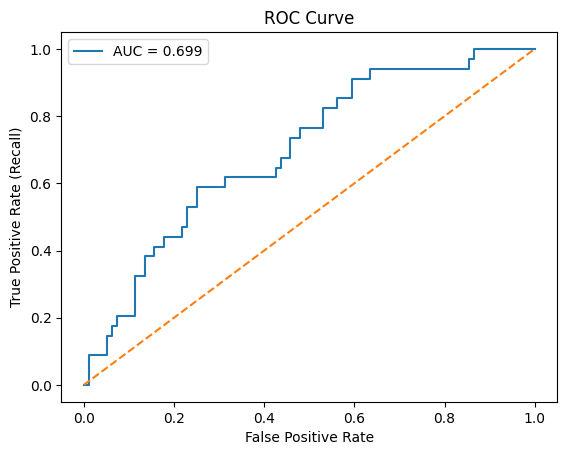

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, probs_ft)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()
